In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed_size = 50
batch_sizes = [4]
test_funcs = ["egg", "branin", "hartmann"]
save_file = True

plot_choice_PI = {
        "seq_results": 1, 
        "random_results": 1,
        "random1_results": 1,
        "kb_results": 0,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 0
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

aggr_seed = "mean"

## Line Plots

random_results
seq_results
cl_min_results
random1_results
Saved as: Exp_Data/Graphs/PI_4-Batch on egg Function (mean, 50 seed).png
random_results
seq_results
cl_min_results
random1_results
Saved as: Exp_Data/Graphs/PI_4-Batch on branin Function (mean, 50 seed).png
random_results
seq_results
cl_min_results
random1_results
Saved as: Exp_Data/Graphs/PI_4-Batch on hartmann Function (mean, 50 seed).png


<Figure size 432x288 with 0 Axes>

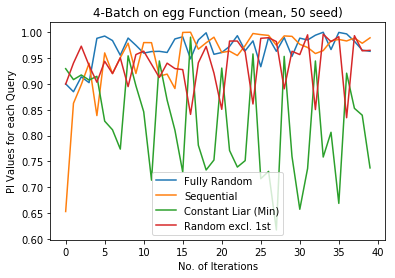

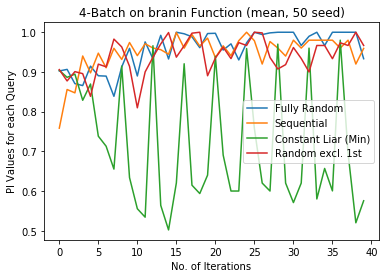

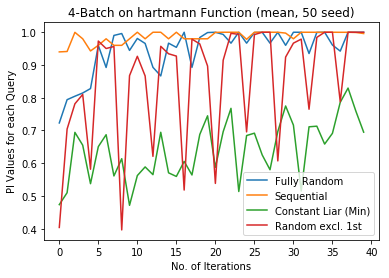

In [5]:
def cumulative_PI_score(func = "egg", seed_size = 2, batch = False, batch_size = 2, heuristic = "sequential", 
                        aggr_seed = aggr_seed):
    # Calculates cumulative PI score of all queries, which is an indication of 'exploitative-ness'
    all_seed_PI = np.array([])
    
    for i in range(seed_size):
        if batch == False:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" \
            + str(i) + "_seed/"
            file_name = dir_name + "sequential,intermediate_vars.pickle"
        
        else:
            dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
            + str(i) + "_seed/"
            file_name = dir_name + heuristic + ',intermediate_vars.pickle'
        
        with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
            pickle_dict = pickle.load(f)
            PI_score = pickle_dict['PI_values']
                       
            # Sequential: self.full_PI_value[:, k] = PI_value
            # Batch: self.full_PI_value[batch number, number within batch, :]
            if batch == True: # If batch, reshape into sequantial format
                PI_score = PI_score.reshape(PI_score.shape[-1], -1)
                
        if all_seed_PI.shape == (0,):
            all_seed_PI = PI_score
        else:
            all_seed_PI = np.vstack((all_seed_PI, PI_score))
            
    if aggr_seed == "mean":
        return np.mean(all_seed_PI, axis = 0)

    if aggr_seed == "median":
        return np.median(all_seed_PI, axis = 0)

def plot_cumulative_PI_score(seed_size, batch_sizes, test_funcs, plot_choice, save_file):
    # Loads, plots and saves graphs     
    for batch_size in batch_sizes:
        plt.figure() # New figure
        for func in test_funcs:
            plt.figure() # New figure
            try:
                seq_results = cumulative_PI_score(batch = False, func = func, batch_size = batch_size, seed_size = seed_size)   
            except: pass
            try:
                random_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = 30, heuristic = "random")
            except: pass
            try:
                random1_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                      seed_size = 30, heuristic = "random_except_1st")
            except: pass
            try:
                kb_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                 seed_size = seed_size, heuristic = "kb")
            except: pass
            try:
                cl_mean_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                      seed_size = seed_size, heuristic = "cl-mean")
            except: pass
            try:
                cl_min_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = seed_size, heuristic = "cl-min")
            except: pass
            try:
                cl_max_results = cumulative_PI_score(func = func, batch = True, batch_size = batch_size, \
                                                     seed_size = seed_size, heuristic = "cl-max")
            except: pass
            
            no_iterations = seq_results.shape[0]
            
            for key, value in plot_choice.items():
                if value == 1:
                    # fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", label = label_lookup[key])
                    print(key)
                    fig = sns.lineplot(x = np.arange(no_iterations), y = eval(key), label = label_lookup[key], estimator = aggr_seed)
            
            graph_title = str(batch_size) + "-Batch on "+ str(func) + " Function " + "(" + str(aggr_seed) + ", " + \
            str(seed_size) + " seed)" 
            ""
            fig.set(xlabel = "No. of Iterations", ylabel = "PI Values for each Query", title = graph_title)
            
            save_path = "Exp_Data/Graphs/" + "PI_" + graph_title + ".png"
            fig2 = fig.get_figure()
            if save_file:
                print("Saved as: " + save_path)
                fig2.savefig(save_path)

plot_cumulative_PI_score(seed_size, batch_sizes, test_funcs, plot_choice_PI, save_file)

In [26]:
random_result

array([0.90002281, 0.88479606, 0.9136423 , 0.90235238, 0.98821743,
       0.9926071 , 0.98391884, 0.95549725, 0.98873031, 0.97472053,
       0.95956716, 0.96260098, 0.96306096, 0.96082711, 0.98706826,
       0.99116224, 0.94846472, 0.98512534, 0.99892287, 0.95729365,
       0.96073778, 0.97260391, 0.99332674, 0.96411254, 0.98326263,
       0.93326043, 0.98978358, 0.96304736, 0.98974409, 0.95332028,
       0.98858032, 0.98501563, 0.99427413, 0.99996914, 0.9665584 ,
       0.99967125, 0.99679219, 0.98245683, 0.9653946 , 0.96315062])

## Table (to be completed)

In [3]:
def single_PI_score(func = "branin", seed_size = 30, batch = False, batch_size = 2, heuristic = "sequential"):
    # Calculates cumulative PI score of all queries, which is an indication of 'exploitative-ness'
    all_seed_PI = np.array([])
    
    for i in range(seed_size):
        if batch == False:
            dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential" + \
            + str(i) + "_seed/"
            filename = dir_name + "sequential,intermediate_vars.pickle"
        
        else:
            dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
            + str(i) + "_seed/"
            file_name = dir_name + heuristic + ',intermediate_vars.pickle'
        
        try: # in case file does not exist, return 0
            with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
                pickle_dict = pickle.load(f)
                PI_score = pickle_dict['PI_values']

                # Sequential: self.full_PI_value[:, k] = PI_value
                # Batch: self.full_PI_value[batch number, number within batch, :]
                if batch == True: # If batch, reshape into sequantial format
                    PI_score = PI_score.reshape(PI_score.shape[-1], -1)
        except:
            print(file_name + " not found.")
            return 0, 0

        if all_seed_PI.shape == (0,):
            all_seed_PI = PI_score
        else:
            all_seed_PI = np.vstack((all_seed_PI, PI_score))
            
    mean_results = np.mean(all_seed_PI)
    median_results np.median(all_seed_PI)
    
    return mean_results, median_results

def all_PI_score(test_funcs, batch_sizes, seed_size = 30):
    for current_batch_size in batch_sizes:
        for func in test_funcs:
            seq_mean, seq_median = single_PI_score(func = func, seed_size = seed_size, batch = False)
            kb_mean, kb_median = single_PI_score(func = func, seed_size = seed_size, batch = True, batch_size = 
                                                current_batch_size, heuristic = "kb")
            
cumulative_PI_score_table()

SyntaxError: invalid syntax (<ipython-input-3-dc5ab2e40695>, line 33)